<a href="https://colab.research.google.com/github/mchchoi/permutation/blob/main/Blume-Capel_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<Figure size 1400x600 with 0 Axes>

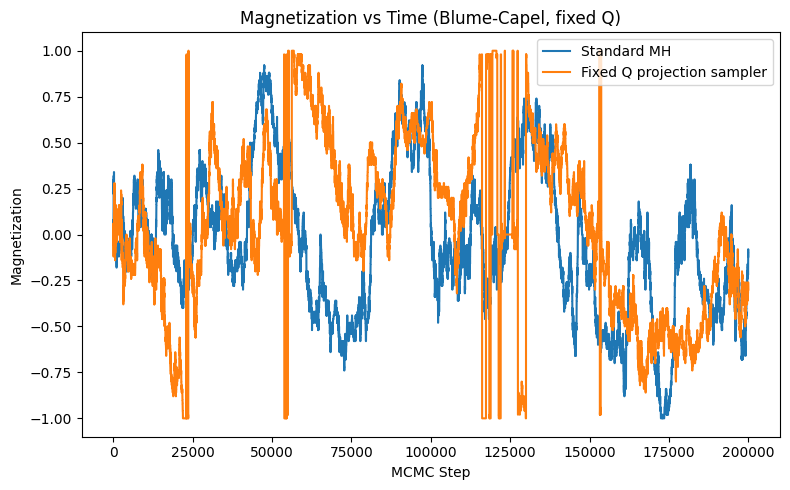

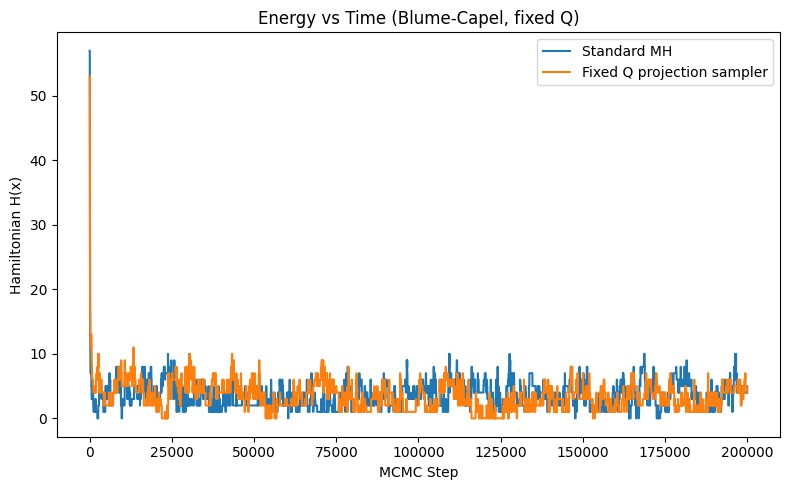

In [1]:
import numpy as np
import matplotlib.pyplot as plt

d = 50                  # Number of spins
n_steps = 200000        # Number of MCMC steps
beta = 3                # Inverse temperature
np.random.seed(30)

# --- Blume-Capel Hamiltonian on the line ---
def hamiltonian(x):
    """H(x) = sum_{i=1}^{d-1} (sigma_i - sigma_{i+1})^2"""
    return np.sum((x[:-1] - x[1:])**2)

# --- Metropolis-Hastings step for Blume-Capel ---
def metropolis_step(x):
    """Propose changing a spin to another value in {-1, 0, +1}."""
    x_new = x.copy()
    i = np.random.randint(0, d)
    current_val = x[i]
    proposal_vals = [-1, 0, 1]
    proposal_vals.remove(current_val)  # Avoid proposing the same value
    x_new[i] = np.random.choice(proposal_vals)
    delta_H = hamiltonian(x_new) - hamiltonian(x)
    if np.random.rand() < np.exp(-beta * delta_H):
        return x_new
    else:
        return x

# --- Involution Q: Flip all non-constant configurations ---
def Q_permutation(x):
    """Q(x) = -x unless x is constant (+1, -1, or 0)."""
    if np.all(x == 1) or np.all(x == -1) or np.all(x == 0):
        return x.copy()
    else:
        return -x.copy()

def Q2_permutation(x):
    """Q2 swaps all-ones and all-zeros states; identity elsewhere."""
    if np.all(x == 1):
        return np.zeros_like(x)
    elif np.all(x == 0):
        return np.ones_like(x)
    else:
        return x.copy()

# --- Projection sampler step \overline{P}(Q) = \dfrac{1}{4}\left(P_\beta + Q_\sigma P_\beta Q_\sigma + Q_\psi P_\beta Q_\psi + Q_\psi Q_\sigma P_\beta Q_\sigma Q_\psi \right). ---
def metropolis_step_modified(x):
    y1 = metropolis_step(x)
    y2 = Q_permutation(metropolis_step(Q_permutation(x)))
    y3 = Q2_permutation(metropolis_step(Q2_permutation(x)))
    inner = Q_permutation(Q2_permutation(x))
    y4 = Q2_permutation(Q_permutation(metropolis_step(inner)))

    choice = np.random.randint(4)
    if choice == 0:
        return y1
    elif choice == 1:
        return y2
    elif choice == 2:
        return y3
    else:
        return y4

# --- Magnetization ---
def magnetization(x):
    return np.mean(x)

# --- Initialization ---
state_std = np.random.choice([-1, 0, 1], size=d)
#state_std = np.ones(shape=d)
state_mod = state_std.copy()

mag_std = np.zeros(n_steps)
mag_mod = np.zeros(n_steps)
energy_std = np.zeros(n_steps)
energy_mod = np.zeros(n_steps)

# --- Run both samplers ---
for t in range(n_steps):
    state_std = metropolis_step(state_std)
    state_mod = metropolis_step_modified(state_mod)

    mag_std[t] = magnetization(state_std)
    mag_mod[t] = magnetization(state_mod)
    energy_std[t] = hamiltonian(state_std)
    energy_mod[t] = hamiltonian(state_mod)

# --- Optional: Plot results ---
plt.figure(figsize=(14, 6))

# Magnetization
plt.figure(figsize=(8, 5))
plt.plot(mag_std, label='Standard MH')
plt.plot(mag_mod, label='Fixed Q projection sampler')
plt.xlabel('MCMC Step')
plt.ylabel('Magnetization')
plt.title('Magnetization vs Time (Blume-Capel, fixed Q)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('BC_magnetization_fixed.png')
plt.show()

# Hamiltonian plot
plt.figure(figsize=(8, 5))
plt.plot(energy_std, label='Standard MH')
plt.plot(energy_mod, label='Fixed Q projection sampler')
plt.xlabel('MCMC Step')
plt.ylabel('Hamiltonian H(x)')
plt.title('Energy vs Time (Blume-Capel, fixed Q)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('BC_energy_fixed.png')
plt.show()

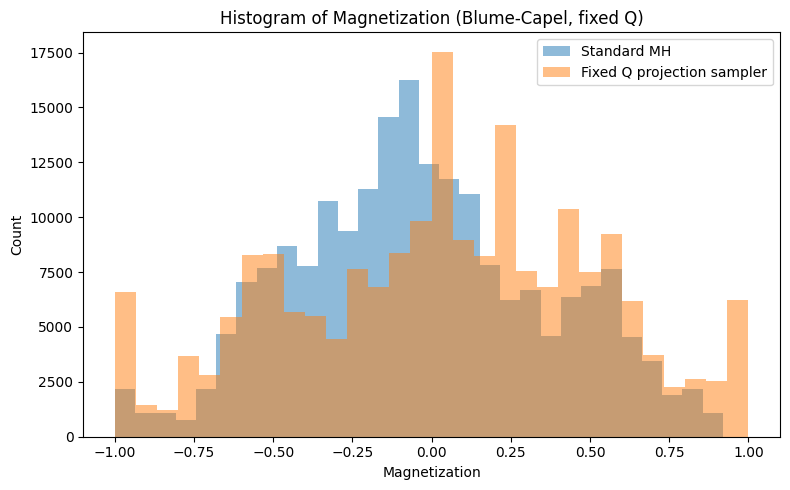

In [4]:
plt.figure(figsize=(8, 5))
plt.hist(mag_std[-200000:], bins=30, alpha=0.5, label='Standard MH', density=False)
plt.hist(mag_mod[-200000:], bins=30, alpha=0.5, label='Fixed Q projection sampler', density=False)
plt.xlabel('Magnetization')
plt.ylabel('Count')
plt.title('Histogram of Magnetization (Blume-Capel, fixed Q)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('BC_histogram_fixed.png')
plt.show()